# Full evaluation of time context in EMG signals 
We use different features to see if they all agree on the context information of the signals, i.e. how much memory is needed to correclty classify the signals. Signals are soming from 3 classes rock/paper/scissor.

In [28]:
from os import listdir
from os.path import isfile, join
import sys
import copy
import re
import numpy as np

from scipy.signal import stft
import scipy.io as sio
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import csv

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tqdm import tqdm
from utils import Person, simple_low_pass, exp_feat, window_spikes, analyze, do_tc_full
import pickle as pkl
import peakutils
import pywt

In [29]:
fs = 200  # sampling frequency of MYO
VERBOSE = True
data_dir = '/Users/enea/Dropbox/Capocaccia2019_Gesture_DVS_Myo/Dataset/'
classes = classes = ['pinky', 'elle', 'yo', 'index', 'thumb']

## Data loading and preprocessing
Simply loading the data, concatenate all trials by all subjects and cut beginning and end of trials for cleaner signals. 

In [30]:
subjects = {}
names = [name for name in listdir(data_dir) if "emg" in name]
for name in names:
    _emg = np.load(data_dir + '{}'.format(name)).astype('float32')
    _ann = np.concatenate([np.array(['none']), np.load(data_dir + '{}'.format(name.replace("emg","ann")))[:-1]])
    
    subjects[name.split("_")[1]] = Person(name.split("_")[1], _emg, _ann, classes=classes)
    
    if VERBOSE:
        print("Loaded {}: EMG = [{}] // ANN = [{}]".format(name.split("_")[1], _emg.shape, len(_ann)))
print("Data Loaded! {} Sessions".format(len(subjects.keys())))

Loaded Charlotte1: EMG = [(25315, 8)] // ANN = [25315]
Loaded Simone3: EMG = [(25324, 8)] // ANN = [25324]
Loaded Enea3: EMG = [(25242, 8)] // ANN = [25242]
Loaded Marcus1: EMG = [(25294, 8)] // ANN = [25294]
Loaded Gemma1: EMG = [(24993, 8)] // ANN = [24993]
Loaded Bruno2: EMG = [(25331, 8)] // ANN = [25331]
Loaded Erika3: EMG = [(25332, 8)] // ANN = [25332]
Loaded Lyes3: EMG = [(25240, 8)] // ANN = [25240]
Loaded Baris3: EMG = [(25244, 8)] // ANN = [25244]
Loaded Simone2: EMG = [(25318, 8)] // ANN = [25318]
Loaded Bruno3: EMG = [(25318, 8)] // ANN = [25318]
Loaded Enea2: EMG = [(25328, 8)] // ANN = [25328]
Loaded Erika2: EMG = [(25330, 8)] // ANN = [25330]
Loaded Lyes2: EMG = [(25304, 8)] // ANN = [25304]
Loaded Baris2: EMG = [(25089, 8)] // ANN = [25089]
Loaded Melika1: EMG = [(25140, 8)] // ANN = [25140]
Loaded Gemma3: EMG = [(24903, 8)] // ANN = [24903]
Loaded Marcus3: EMG = [(25328, 8)] // ANN = [25328]
Loaded Enea1: EMG = [(25315, 8)] // ANN = [25315]
Loaded Simone1: EMG = [(253

In [31]:
# separates data in correct trial type

for name, data in subjects.items():
    for _class in classes:
        _annotation = np.float32(data.ann == _class)
        derivative = np.diff(_annotation)/1.0
        begins = np.where(derivative == 1)[0]
        ends = np.where(derivative == -1)[0]
        for b, e in zip(begins, ends):
            _trials = data.emg[b:e]
            data.trials[_class].append(_trials)
print("Done sorting trials!")

Done sorting trials!


In [32]:
# Concat all trials/all people.
threshold = 50  # samples
min_step = 100  # samples
filter_name = ''
all_trials = {c: [] for c in classes}

for _all, _class in zip([a for _, a in all_trials.items()], classes):
    for name, data in [(k, v) for (k, v) in subjects.items() if filter_name in k]:
        for i in range(len(data.trials[_class])):
            _sig = copy.deepcopy(data.trials[_class][i])
            _sig = _sig[threshold:]
            leftover = len(_sig) // min_step
            _normed = _sig[:leftover * min_step]
            _all.append(_normed)

# I concat all of them 
all_trials = {k: np.vstack(a) for k, a in all_trials.items()}

if VERBOSE:
    for k, v in all_trials.items():
        print(v.shape)

overall_std = np.std(np.vstack([a for _, a in all_trials.items()]))
    
all_trials = {k: a / overall_std for k, a in all_trials.items()}
print("All data ready!")

(45000, 8)
(44900, 8)
(44900, 8)
(44700, 8)
(45000, 8)
All data ready!


# Time context for various features

## SVM on FFT features

In [ ]:
n_ch = 8
window = 2
splits = 10
nfft = 35

all_X, all_Y = [], []

for idx, subset in enumerate([a for _, a in all_trials.items()]):
    subset = subset[:, :n_ch]
    feat = n_ch * (nfft // 2 + 1)
    _sub = np.abs(stft(subset[:, :].T, nperseg=nfft, noverlap=0)[-1]).reshape(feat, -1).T ** 0.3
    all_X.append(_sub)
    all_Y.append(np.ones((_sub.shape[0],1)) * idx)

all_X = np.vstack(all_X)
all_Y = np.vstack(all_Y)

all_X -= np.mean(all_X, 0, keepdims=True)
all_X /= np.std(all_X, 0, keepdims=True) + 1e-15

print(do_tc_full(all_X, all_Y, verbose=True, pca_comp=100))

## SVM on various time features

In [34]:
all_X, all_Y = [], []
n_ch = 8
preprocess = True
frame_len = 0.125
overlap = 0.3
frame_step = frame_len * (1. - overlap)
features = ['MAV', 'RMS', 'SD']
n_comp = 8
for idx, subset in enumerate([a for _, a in all_trials.items()]):
    subset = subset[:, :n_ch]
    feat = n_ch * 1
    _sub = [analyze(subset, frame_len=frame_len, frame_step=frame_step, feat=f, preprocess=False) for f in features]
    _sub = np.hstack(_sub)
    all_X.append(_sub)
    all_Y.append(np.ones((_sub.shape[0],1)) * idx)

all_X = np.vstack(all_X)
all_Y = np.vstack(all_Y)

all_X -= np.mean(all_X, 0, keepdims=True)
all_X /= np.std(all_X, 0, keepdims=True) + 1e-15

acc_tr, acc_te = do_tc_full(all_X, all_Y, verbose=True, pca_comp=n_comp, avg=False)
print("Train: {:.4} +/- {:.4}".format(np.mean(acc_tr), np.std(acc_tr)))
print("Test: {:.4} +/- {:.4}".format(np.mean(acc_te), np.std(acc_te)))

with open('res_rps_10_p.csv', 'a') as f:
    csv_writer = csv.writer(f)
    # subject,feat,frame_len,frame_step,n_comp,acc_tr,acc_te
    for a_tr, a_te in zip(acc_tr, acc_te):
        csv_writer.writerow([filter_name, "-".join(features), frame_len, frame_step, n_comp, a_tr, a_te])

Features: 24 => 8
Train on: 11876 / Test on 1319
Fold 0: Train acc: 0.833 || Test acc: 0.807
Fold 1: Train acc: 0.834 || Test acc: 0.783
Fold 2: Train acc: 0.834 || Test acc: 0.796
Fold 3: Train acc: 0.832 || Test acc: 0.817
Fold 4: Train acc: 0.831 || Test acc: 0.817
Fold 5: Train acc: 0.832 || Test acc: 0.808
Fold 6: Train acc: 0.831 || Test acc: 0.82
Fold 7: Train acc: 0.833 || Test acc: 0.792
Fold 8: Train acc: 0.831 || Test acc: 0.799
Fold 9: Train acc: 0.834 || Test acc: 0.788
Train: 0.8327 +/- 0.00137
Test: 0.8027 +/- 0.01238


In [44]:
with open('res_gest_10_p.csv', 'w') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(['subject','feat','frame_len','frame_step','n_comp','acc_tr','acc_te'])
# A bunch all together
for filter_name in ['Charlotte', 'Enea', 'Melika', 'Baris', 'Bruno', 'Erika', 'Gemma', 'Lyes', 'Simone', 'Marcus']:
    threshold = 50  # samples
    min_step = 100  # samples
    all_trials = {c: [] for c in classes}

    for _all, _class in zip([a for _, a in all_trials.items()], classes):
        for name, data in [(k, v) for (k, v) in subjects.items() if filter_name in k]:
            for i in range(len(data.trials[_class])):
                _sig = copy.deepcopy(data.trials[_class][i])
                _sig = _sig[threshold:]
                leftover = len(_sig) // min_step
                _normed = _sig[:leftover * min_step]
                _all.append(_normed)

    # I concat all of them 
    all_trials = {k: np.vstack(a) for k, a in all_trials.items()}

    if VERBOSE:
        for k, v in all_trials.items():
            print(v.shape)

    overall_std = np.std(np.vstack([a for _, a in all_trials.items()]))

    all_trials = {k: a / overall_std for k, a in all_trials.items()}
    print("All data ready!")

    for n_comp in [8]:
        for frame_len in [0.125, 0.25]:
            for overlap in [0.25]:
                print("{}::{}::{}::{}".format(filter_name, n_comp, frame_len, frame_step))
                all_X, all_Y = [], []
                n_ch = 8
                frame_step = frame_len * (1. - overlap)
                features = ['MAV', 'RMS', 'SD']
                for idx, subset in enumerate([a for _, a in all_trials.items()]):
                    subset = subset[:, :n_ch]
                    feat = n_ch * 1
                    _sub = [analyze(subset, frame_len=frame_len, frame_step=frame_step, feat=f, preprocess=False) for f in features]
                    _sub = np.hstack(_sub)
                    all_X.append(_sub)
                    all_Y.append(np.ones((_sub.shape[0],1)) * idx)

                all_X = np.vstack(all_X)
                all_Y = np.vstack(all_Y)

                all_X -= np.mean(all_X, 0, keepdims=True)
                all_X /= np.std(all_X, 0, keepdims=True) + 1e-15

                acc_tr, acc_te = do_tc_full(all_X, all_Y, verbose=False, pca_comp=n_comp, avg=False)
                print("Train: {:.4} +/- {:.4}".format(np.mean(acc_tr), np.std(acc_tr)))
                print("Test: {:.4} +/- {:.4}".format(np.mean(acc_te), np.std(acc_te)))

                with open('res_gest_10_p.csv', 'a') as f:
                    csv_writer = csv.writer(f)
                    # subject,feat,frame_len,frame_step,n_comp,acc_tr,acc_te
                    for a_tr, a_te in zip(acc_tr, acc_te):
                        csv_writer.writerow([filter_name, "-".join(features), frame_len, frame_step, n_comp, a_tr, a_te])

(4500, 8)
(4500, 8)
(4500, 8)
(4500, 8)
(4500, 8)
All data ready!
Charlotte::8::0.125::0.1875
Train: 0.9566 +/- 0.002477
Test: 0.9169 +/- 0.02165
Charlotte::8::0.25::0.09375
Train: 0.9846 +/- 0.003318
Test: 0.95 +/- 0.02108
(4500, 8)
(4500, 8)
(4500, 8)
(4500, 8)
(4500, 8)
All data ready!
Enea::8::0.125::0.1875
Train: 0.9199 +/- 0.00193
Test: 0.8306 +/- 0.0357
Enea::8::0.25::0.09375
Train: 0.96 +/- 0.002772
Test: 0.8817 +/- 0.02409
(4500, 8)
(4400, 8)
(4400, 8)
(4200, 8)
(4500, 8)
All data ready!
Melika::8::0.125::0.1875
Train: 0.9806 +/- 0.001576
Test: 0.9545 +/- 0.01535
Melika::8::0.25::0.09375
Train: 0.9934 +/- 0.00127
Test: 0.9724 +/- 0.03465
(4500, 8)
(4500, 8)
(4500, 8)
(4500, 8)
(4500, 8)
All data ready!
Baris::8::0.125::0.1875
Train: 0.9024 +/- 0.002517
Test: 0.7766 +/- 0.03124
Baris::8::0.25::0.09375
Train: 0.9398 +/- 0.004917
Test: 0.815 +/- 0.04969
(4500, 8)
(4500, 8)
(4500, 8)
(4500, 8)
(4500, 8)
All data ready!
Bruno::8::0.125::0.1875
Train: 0.9341 +/- 0.002897
Test: 0.843

Text(0, 0.5, 'Accuracy')

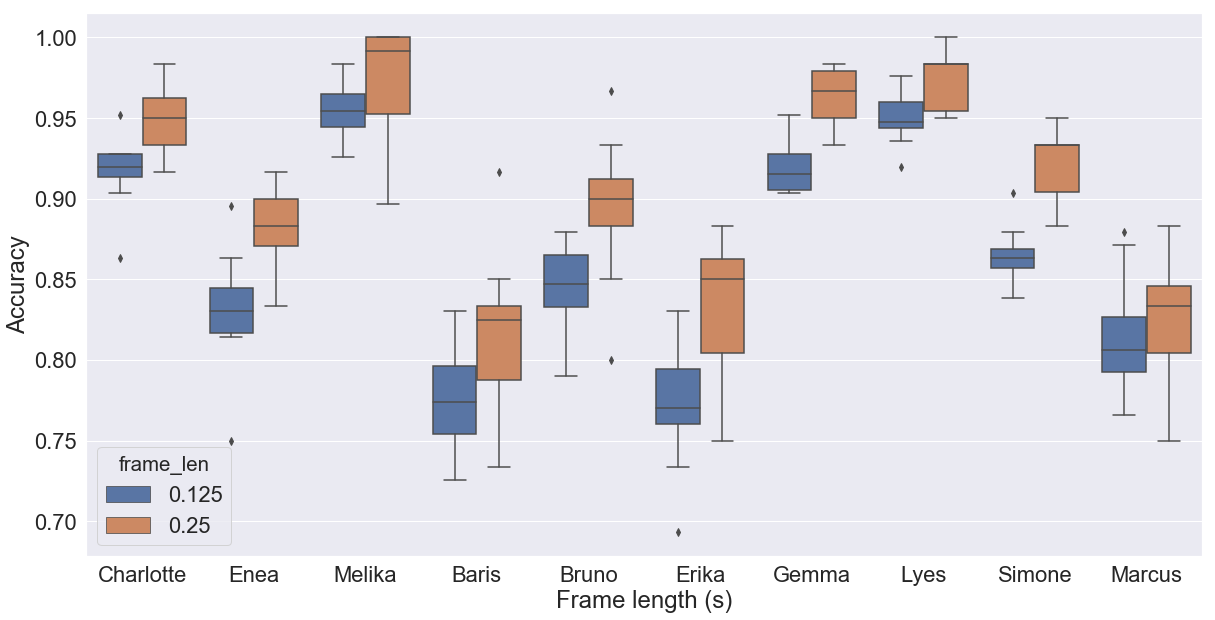

In [47]:
import seaborn as sns
import pandas as pd
from statannot import add_stat_annotation

sns.set(font_scale=2)  # crazy big
plt.figure(figsize=(20,10))

data = pd.read_csv('res_gest_10_p.csv', delimiter=',')
# print(data)
x = 'subject'
y = 'acc_te'
hue = 'frame_len'
ax = sns.boxplot(data=data, x=x, y=y, hue=hue)
# add_stat_annotation(ax, data=data, x=x, y=y, boxPairList=[(0.25, 0.125)],
#                     test='t-test_ind', textFormat='star', loc='outside', verbose=0)
# ax.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.2))
ax.set_xlabel('Frame length (s)')
ax.set_ylabel('Accuracy')
# plt.savefig('rps_per_person.pdf', bbox_inches='tight')

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(all_X)
print(X_embedded.shape)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=all_Y.squeeze())

## SVM on spikes

In [ ]:
spikes = pkl.load(open('sample_based_test_1_3500.0_0.05_0.05_0.0_prec_1_5.pkl', 'rb'))

In [ ]:
all_X, all_Y = [], []

step = 0.010  # 1ms
window = 0.240  # 100ms
s = int(window / step)

all_X, all_Y = [], []
class_idx = {k: j for j, k in enumerate(list(spikes.keys()))}

for name, subset in spikes.items():
    
    _all = []
    for _ts, _ch in zip(subset['ts'], subset['ch']):
        _m = window_spikes(_ts, _ch, w=step, n_ch=16)[:s]
        if _m.shape[0] < s:
            _m = np.vstack([_m, np.zeros((s - _m.shape[0], _m.shape[1]))])
            
        _m = simple_low_pass(_m, win=10, shift=5)
        _all.append(_m)
        
    _all = np.array(_all)
    all_X.append(_all)
    all_Y.append(np.ones((_all.shape[0], 1)) * class_idx[name])

all_X = np.vstack(all_X)
all_Y = np.vstack(all_Y)
all_X = np.reshape(all_X, (all_X.shape[0], -1))

all_X -= np.mean(all_X, 0, keepdims=True)
all_X /= np.std(all_X, 0, keepdims=True) + 1e-15

print(all_X.shape)
# print(do_tc_full(all_X, all_Y, verbose=True, do_pca=True))

In [ ]:
acc_tr, acc_te, std_tr, std_te = do_tc_full(all_X, all_Y, verbose=True, pca_comp=16)
print("Train: {:.4} +/- {:.4}".format(acc_tr, std_tr))
print("Test: {:.4} +/- {:.4}".format(acc_te, std_te))